<a href="https://colab.research.google.com/github/aLehav/HackSC2022-JAARS/blob/main/BEATs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Link to BEATs Github](https://github.com/microsoft/unilm/tree/master/beats)

In [1]:
!git clone https://github.com/microsoft/unilm.git
%cd unilm/beats

Cloning into 'unilm'...
remote: Enumerating objects: 7293, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 7293 (delta 0), reused 3 (delta 0), pack-reused 7289
Receiving objects: 100% (7293/7293), 17.57 MiB | 17.18 MiB/s, done.
Resolving deltas: 100% (3064/3064), done.
/content/unilm/beats


In [2]:
import io
import torch
from Tokenizers import TokenizersConfig, Tokenizers
from BEATs import BEATs, BEATsConfig

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
%cd ../../drive/MyDrive/video_summarization/
!ls

/content/drive/MyDrive/video_summarization
91IHQYk1IQM.mp3					 qqR6AEXwxoQ.mp3
91IHQYk1IQM.wav					 qqR6AEXwxoQ.wav
BEATs_iter3_plus_AS2M_finetuned_on_AS2M_cpt2.pt  Tokenizer_iter3_plus_AS2M.pt
BEATs_iter3_plus_AS2M.pt


In [5]:
# checkpoint = torch.load('Tokenizer_iter3_plus_AS2M.pt')
# checkpoint = torch.load('BEATs_iter3_plus_AS2M.pt')
checkpoint = torch.load('BEATs_iter3_plus_AS2M_finetuned_on_AS2M_cpt2.pt')

In [6]:
# load the pre-trained checkpoints

# audio_input_16khz = torch.randn(1, 10000)
# padding_mask = torch.zeros(1, 10000).bool()

# for a tokenizer
# cfg = TokenizersConfig(checkpoint['cfg'])
# BEATs_tokenizer = Tokenizers(cfg)
# BEATs_tokenizer.load_state_dict(checkpoint['model'])
# BEATs_tokenizer.eval()

# labels = BEATs_tokenizer.extract_labels(audio_input_16khz, padding_mask=padding_mask)


#for pretrained
# cfg = BEATsConfig(checkpoint['cfg'])
# BEATs_model = BEATs(cfg)
# BEATs_model.load_state_dict(checkpoint['model'])
# BEATs_model.eval()

# representation = BEATs_model.extract_features(audio_input_16khz, padding_mask=padding_mask)[0]

#for fine-tuned
cfg = BEATsConfig(checkpoint['cfg'])
BEATs_model = BEATs(cfg)
BEATs_model.load_state_dict(checkpoint['model'])
BEATs_model.eval()  

BEATs(
  (post_extract_proj): Linear(in_features=512, out_features=768, bias=True)
  (patch_embedding): Conv2d(1, 512, kernel_size=(16, 16), stride=(16, 16), bias=False)
  (dropout_input): Dropout(p=0.0, inplace=False)
  (encoder): TransformerEncoder(
    (pos_conv): Sequential(
      (0): Conv1d(768, 768, kernel_size=(128,), stride=(1,), padding=(64,), groups=16)
      (1): SamePad()
      (2): GELU(approximate='none')
    )
    (layers): ModuleList(
      (0): TransformerSentenceEncoderLayer(
        (self_attn): MultiheadAttention(
          (dropout_module): Dropout(p=0.0, inplace=False)
          (relative_attention_bias): Embedding(320, 12)
          (k_proj): Linear(in_features=768, out_features=768, bias=True)
          (v_proj): Linear(in_features=768, out_features=768, bias=True)
          (q_proj): Linear(in_features=768, out_features=768, bias=True)
          (out_proj): Linear(in_features=768, out_features=768, bias=True)
          (grep_linear): Linear(in_features=64, out

In [8]:
!pip install boto3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 KB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 94.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 KB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 18.2 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [9]:
import torchaudio
import io
import os
import tarfile
import tempfile

import boto3
import matplotlib.pyplot as plt
import requests
from botocore import UNSIGNED
from botocore.config import Config
from IPython.display import Audio

In [10]:
print(torchaudio.info("qqR6AEXwxoQ.wav"))
print(torchaudio.info('91IHQYk1IQM.wav'))
waveform, sample_rate = torchaudio.load("91IHQYk1IQM.wav")

AudioMetaData(sample_rate=44100, num_frames=11879424, num_channels=2, bits_per_sample=16, encoding=PCM_S)
AudioMetaData(sample_rate=16000, num_frames=1768432, num_channels=1, bits_per_sample=16, encoding=PCM_S)


In [11]:
audio_input_16khz = waveform
print(waveform.shape[1])
len = audio_input_16khz.shape[1]
padding_mask = torch.zeros(1,len).bool()

1768432


In [12]:
probs = BEATs_model.extract_features(audio_input_16khz, padding_mask=padding_mask)[0]

for i, (top5_label_prob, top5_label_idx) in enumerate(zip(*probs.topk(k=5))):
    top5_label = [checkpoint['label_dict'][label_idx.item()] for label_idx in top5_label_idx]
    print(f'Top 5 predicted labels of the {i}th audio are {top5_label} with probability of {top5_label_prob}')

Top 5 predicted labels of the 0th audio are ['/m/04rlf', '/m/07qnq_y', '/m/0326g', '/m/04szw', '/m/07qcpgn'] with probability of tensor([0.9225, 0.3113, 0.0732, 0.0566, 0.0528], grad_fn=<UnbindBackward0>)


##Pretrained on [AudioSet](https://ieeexplore-ieee-org.libproxy2.usc.edu/stamp/stamp.jsp?tp=&arnumber=7952261) dataset with [ontology](https://github.com/audioset/ontology/blob/master/ontology.json).
##Output is then:\

|Label|Probability|
|-|-|
|Music|0.9225|
|Thump, thud|0.3113|
|Flamenco|0.0732|
|Muical instrument|0.0566|
|Tap|0.0528|


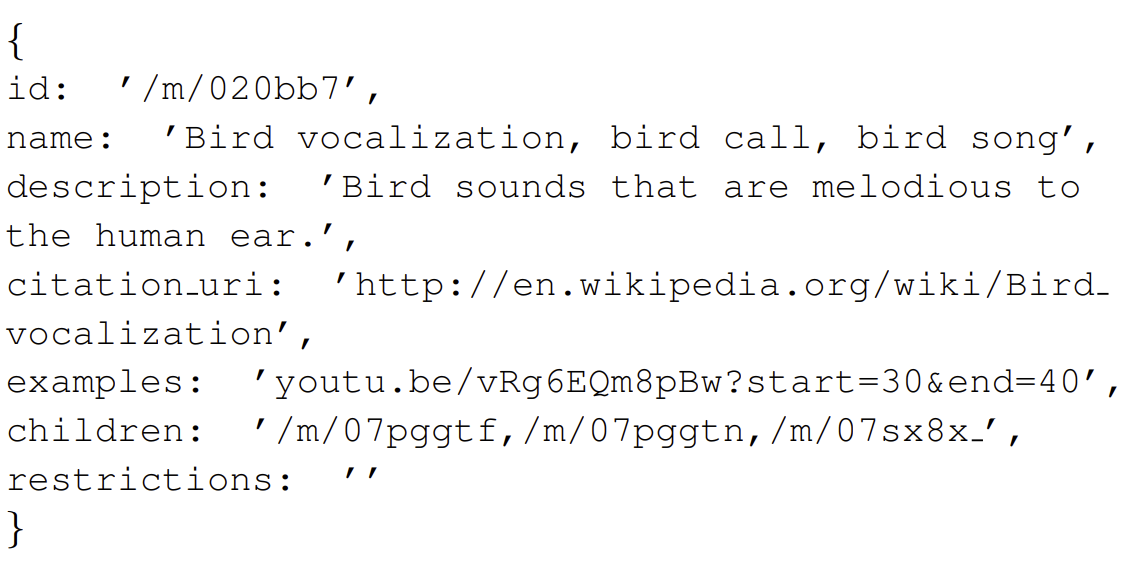